# **Assignment 4: Natural Language Processing (NLP)**

By Rayce Ramsay, Kenta Ploch, and Justin Won (Group 5)

In [ ]:
# Imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from google.colab import files
from datetime import datetime
import io
import nltk
import re
from nltk.stem.porter import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

## **PART 1 - Sentiment Analysis with a Twitter Dataset**

In [ ]:
# Download the Data sets

# Download the training data set here
train_data = pd.read_csv('covid-tweets-train.csv')

# Download the test data set here
test_data = pd.read_csv('covid-tweets-test.csv')

In [ ]:
# Do data cleaning

# Remove rows with missing labels
train_data = train_data.dropna(subset=['Sentiment'])

# Convert 'Sentiment' column to numeric, coerce errors to convert non-numeric values to NaN
train_data['Sentiment'] = pd.to_numeric(train_data['Sentiment'], errors='coerce')

# Remove rows with non-numeric sentiment scores
train_data = train_data.dropna(subset=['Sentiment'])

# Remove rows with missing labels
test_data = test_data.dropna(subset=['Sentiment'])

# Convert 'Sentiment' column to numeric, coerce errors to convert non-numeric values to NaN
test_data['Sentiment'] = pd.to_numeric(test_data['Sentiment'], errors='coerce')

# Remove rows with non-numeric sentiment scores
test_data = test_data.dropna(subset=['Sentiment'])

### A) Consider the training data. What is the balance between the three classes? In other words, what proportion of the observations (in the training set) belong to each class?


In [ ]:
sentiment_counts = train_data['Sentiment'].value_counts()
total_samples = len(train_data)
proportions = sentiment_counts / total_samples

proportions

Sentiment
2.0    0.438434
0.0    0.374159
1.0    0.187407
Name: count, dtype: float64

###B) Tokenize the tweets. In other words, for each observation, convert the tweet from a single string of running text into a list of individual tokens (possibly with punctuation), splitting on whitespace. The result should be that each observation (tweet) is a list of individual tokens.


In [ ]:
# Download the tokenizer
nltk.download('punkt')

# Create a new column in our DF that contains token lists instead of raw text

train_data['tokens'] = train_data['OriginalTweet'].apply(nltk.word_tokenize)

test_data['tokens'] = test_data['OriginalTweet'].apply(nltk.word_tokenize)

train_data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,OriginalTweet,Sentiment,tokens
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1.0,"[@, MeNyrbie, @, Phil_Gahan, @, Chrisitv, http..."
1,1,advice Talk to your neighbours family to excha...,2.0,"[advice, Talk, to, your, neighbours, family, t..."
2,2,Coronavirus Australia: Woolworths to give elde...,2.0,"[Coronavirus, Australia, :, Woolworths, to, gi..."
3,3,My food stock is not the only one which is emp...,2.0,"[My, food, stock, is, not, the, only, one, whi..."
4,4,"Me, ready to go at supermarket during the #COV...",0.0,"[Me, ,, ready, to, go, at, supermarket, during..."
...,...,...,...,...
41150,41150,Airline pilots offering to stock supermarket s...,1.0,"[Airline, pilots, offering, to, stock, superma..."
41151,41151,Response to complaint not provided citing COVI...,0.0,"[Response, to, complaint, not, provided, citin..."
41152,41152,You know itÂs getting tough when @KameronWild...,2.0,"[You, know, itÂs, getting, tough, when, @, Ka..."
41153,41153,Is it wrong that the smell of hand sanitizer i...,1.0,"[Is, it, wrong, that, the, smell, of, hand, sa..."


###C) Using a regular expression, remove any URL tokens from each of the observations.
Hint: In this dataset, all such tokens begin with “http”.

In [ ]:
tokens_no_urls_1 = []
for row in train_data['tokens']:
    tokens_no_urls_1.append([re.sub(r'http\S+', '', token) for token in row])

train_data['tokens_no_urls'] = tokens_no_urls_1

tokens_no_urls_2 = []
for row in test_data['tokens']:
    tokens_no_urls_2.append([re.sub(r'http\S+', '', token) for token in row])

test_data['tokens_no_urls'] = tokens_no_urls_2

###D) Remove all punctuation (,.?!;:’") and special characters(@, #, +, &, =, $, etc). Also, convert all tokens to lowercase only. Can you think of a scenario when you might want to keep some forms of punctuation?


In [ ]:
tokens_no_punct_train = []
# Create a list of lists with what we want
for row in train_data['tokens_no_urls']:
  tokens_no_punct_train.append([re.sub('[^\w\s]','', t) for t in row])
# add the new info to our df
train_data['tokens_no_punct'] = tokens_no_punct_train

tokens_no_punct_test = []
# Create a list of lists with what we want
for row in test_data['tokens_no_urls']:
  tokens_no_punct_test.append([re.sub('[^\w\s]','', t) for t in row])
# add the new info to our df
test_data['tokens_no_punct'] = tokens_no_punct_test


lowercase_tokens_train = []
# Create a list of lists with what we want
for row in train_data['tokens_no_punct']:
  lowercase_tokens_train.append([t.lower() for t in row])
# add the new info to our df
train_data['lowercase_tokens'] = lowercase_tokens_train

lowercase_tokens_test = []
# Create a list of lists with what we want
for row in test_data['tokens_no_punct']:
  lowercase_tokens_test.append([t.lower() for t in row])
# add the new info to our df
test_data['lowercase_tokens'] = lowercase_tokens_test


###E) Now stem your tokens. This will have the effect of converting similar word forms into identical tokens (e.g. run, runs, running → run). Please specify which stemmer you use.

Note: There are several different stemmers available through nltk and Scikit-learn. I recommend the Porter stemmer, but you may use a different one if you wish.


In [ ]:
stemmer = PorterStemmer()

stemmed_tokens_train = []
# Create a list of lists with what we want
for row in train_data['tokens_no_urls']:
  token_stems = [stemmer.stem(w) for w in row]
  stemmed_tokens_train.append(token_stems)
# add the new info to our df
train_data['stemmed_tokens'] = stemmed_tokens_train

stemmed_tokens_test = []
# Create a list of lists with what we want
for row in test_data['tokens_no_urls']:
  token_stems = [stemmer.stem(w) for w in row]
  stemmed_tokens_test.append(token_stems)
# add the new info to our df
test_data['stemmed_tokens'] = stemmed_tokens_test


###F) Lastly, remove stopwords. Using the english stopwords list from nltk, remove these common words from your observations. This list is very long (I think almost 200 words), so remove only the first 100 stopwords in the list.

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

#Get the first 100 stopwprds
sw = stopwords.words('english')[:100]

no_sw_train = []
# Create a list of lists with what we want
for row in train_data['stemmed_tokens']:
  no_sw_train.append([w for w in row if w not in sw])
# add the new info to our train_data
train_data['no_sw'] = no_sw_train

no_sw_test = []
# Create a list of lists with what we want
for row in test_data['stemmed_tokens']:
  no_sw_test.append([w for w in row if w not in sw])
# add the new info to our test_data
test_data['no_sw'] = no_sw_test

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###G) Now convert your lists of words into vectors of word counts. You may find Scikit-learn’s CountVectorizer useful here. What is the length of your vocabulary?

**Hint**: The matrix of counts will be D × V , where D is the number of documents (tweets), and V is the number of features (word counts).


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer # used in next cell
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Convert lists of words into strings
documents = train_data['no_sw'].apply(' '.join)
vectorizer = CountVectorizer(max_features=1000)
train_word_counts = vectorizer.fit_transform(documents)
vocabulary_length = len(vectorizer.get_feature_names_out())

print("Length of the vocabulary:", vocabulary_length)

Length of the vocabulary: 1000


### H) Recall the definition of the Naive Bayes model. If each document (tweet) is a collection of words (w1, · · · , wN ) belonging to class Ck (k = 0, 1, 2), then the Naive Bayes approach models the probability of each tweet belonging to class k:

The last equality follows from our “naive” assumption that words are conditionally independent given class. The probabilities are estimated using the frequencies of words within each class (bag of words), and we assign the class label according to which of the 3 posterior class probabilities (P(Ck|w1,··· ,wN)) is the highest.

Fit a Naive Bayes model to your data. Report the training and test error of the model. Use accuracy as the error metric. Also, report the 5 most probable words in each class, along with their counts. You might find Scikit-learn’s MultinomialNB() transformer useful. Use Laplace smoothing to prevent probabilities of zero.


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve
import matplotlib.pyplot as plt

## For getting the training and testing error rate of the sets ##
nb = MultinomialNB()

x_train = train_word_counts
y_train = train_data['Sentiment']
documents2 = test_data['no_sw'].apply(' '.join)
x_test = vectorizer.fit_transform(documents2)
y_test = test_data['Sentiment']

nb.fit(train_word_counts, y_train)

train_predict = nb.predict(x_train)
test_predict = nb.predict(x_test)

# Subtract accuracy rate from 1 to get error rate
train_accuracy = accuracy_score(y_train, train_predict)
test_accuracy = accuracy_score(y_test, test_predict)

print("Training accuracy:", 1 - train_accuracy)
print("Test accuracy:", 1 - test_accuracy)

Training accuracy: 0.31617700663410364
Test accuracy: 0.5560821484992101


In [ ]:
## For getting the 5 most probable words in each class ##

# Get the feature log probabilities for each class
feature_log_probs = nb.feature_log_prob_

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a dictionary to store the top 5 words for each class
top_words_per_class = {}

for i, class_log_probs in enumerate(feature_log_probs):
    # Get the top 5 words indices for the current class
    top_word_indices = class_log_probs.argsort()[-5:][::-1]
    # Get the corresponding words and their counts
    top_words = [(feature_names[idx], np.exp(class_log_probs[idx])) for idx in top_word_indices]
    # Store the top words in the dictionary
    top_words_per_class[f'Class {i}'] = top_words

for class_name, top_words in top_words_per_class.items():
    print(f"Top 5 words for {class_name}:")
    for word, count in top_words:
        print(f"- {word}: {count}")
    print()

Top 5 words for Class 0:
- co: 0.031546323720038634
- coronaviruspandem: 0.026467330248489667
- 19: 0.019239682926254435
- covid2019: 0.018556198885999582
- practic: 0.017146022044324336

Top 5 words for Class 1:
- co: 0.05986066452304388
- coronaviruspandem: 0.040921757770632367
- 19: 0.02337620578778134
- covid2019: 0.02311897106109323
- strong: 0.01710610932475884

Top 5 words for Class 2:
- co: 0.034832113703009024
- coronaviruspandem: 0.02480648825720552
- 19: 0.018221805405119824
- covid2019: 0.01753824003381501
- strong: 0.012981137558449795



### J) Redo parts G-H using TF-IDF vectors instead of count vectors. You might find Scikitlearn’s TfidfVectorizer() transformer useful. Report the training and test accuracy. How does this compare to the accuracy using count vectors?

In [ ]:
# Redo Part G & H

from sklearn.feature_extraction.text import TfidfVectorizer

documents = train_data['no_sw'].apply(' '.join)
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
train_word_counts = vectorizer_tfidf.fit_transform(documents)

nb = MultinomialNB()

x_train = train_word_counts
y_train = train_data['Sentiment']
documents2 = test_data['no_sw'].apply(' '.join)
x_test = vectorizer_tfidf.fit_transform(documents2)
y_test = test_data['Sentiment']

nb.fit(train_word_counts, y_train)

train_predict = nb.predict(x_train)
test_predict = nb.predict(x_test)

# Subtract accuracy rate from 1 to get error rate
train_accuracy_tfidf = accuracy_score(y_train, train_predict)
test_accuracy_tfidf = accuracy_score(y_test, test_predict)

print("Training accuracy for TD-IDF vector:", train_accuracy_tfidf)
print("Test accuracy for TD-IDF vector:", test_accuracy_tfidf)

Training accuracy for TD-IDF vector: 0.6704089815557338
Test accuracy for TD-IDF vector: 0.44681411269088994


In [ ]:
# Compare this to the accuracies for CountVectorizer

train_difference = abs(train_accuracy - train_accuracy_tfidf)
test_difference = abs(test_accuracy - test_accuracy_tfidf)

if train_accuracy > train_accuracy_tfidf:
  print('CountVectorizer was more accurate by ', train_difference)
elif train_accuracy < train_accuracy_tfidf:
  print('TF-IDF vectorizer was more accurate by ', train_difference)
else: # train_accuracy = train_accuracy_tfidf
  print('They both were equally accurate with accuracy ', train_accuracy)

if test_accuracy > test_accuracy_tfidf:
  print('CountVectorizer was more accurate by ', test_difference)
elif test_accuracy < test_accuracy_tfidf:
  print('TF-IDF vectorizer was more accurate by ', test_difference)
else: # train_accuracy = train_accuracy_tfidf
  print('They both were equally accurate with accuracy', test_accuracy)


CountVectorizer was more accurate by  0.013414011810162552
TF-IDF vectorizer was more accurate by  0.002896261190100058


### K) Recall lemmatization converts each word to its base form, which is a bit stronger than simply taking the stem. Redo parts E-H using TF-IDF vectors instead of count vectors. This time use lemmatization instead of stemming. Report train and test accuracy. How does the accuracy with lemmatization compare to the accuracy with stemming?

In [ ]:
# Redoing Part E
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

lemmatized_tokens_train = []
# Create a list of lists with what we want
for row in train_data['tokens_no_urls']:
  token_lemmatized = [lemmatizer.lemmatize(w) for w in row]
  lemmatized_tokens_train.append(token_lemmatized)
# add the new info to our df
train_data['lemmatized_tokens'] = lemmatized_tokens_train

lemmatized_tokens_test = []
# Create a list of lists with what we want
for row in test_data['tokens_no_urls']:
  token_lemmatized = [lemmatizer.lemmatize(w) for w in row]
  lemmatized_tokens_test.append(token_lemmatized)
# add the new info to our df
test_data['lemmatized_tokens'] = lemmatized_tokens_test

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Redoing Part F

#Get the first 100 stopwprds
sw = stopwords.words('english')[:100]

no_sw_train_2 = []
# Create a list of lists with what we want
for row in train_data['lemmatized_tokens']:
  no_sw_train_2.append([w for w in row if w not in sw])
# add the new info to our train_data
train_data['no_sw_lemmatized'] = no_sw_train_2

no_sw_test_2 = []
# Create a list of lists with what we want
for row in test_data['lemmatized_tokens']:
  no_sw_test_2.append([w for w in row if w not in sw])
# add the new info to our test_data
test_data['no_sw_lemmatized'] = no_sw_test_2

In [ ]:
# Redo Part G & H

lemmatized_documents = train_data['no_sw_lemmatized'].apply(' '.join)
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
train_word_counts_lemmatized = vectorizer_tfidf.fit_transform(lemmatized_documents)

nb = MultinomialNB()

x_train_lemmatized = train_word_counts_lemmatized
y_train_lemmatized = train_data['Sentiment']
documents2_lemmatized = test_data['no_sw_lemmatized'].apply(' '.join)
x_test_lemmatized = vectorizer_tfidf.fit_transform(documents2_lemmatized)
y_test_lemmatized = test_data['Sentiment']

nb.fit(train_word_counts_lemmatized, y_train_lemmatized)

train_predict = nb.predict(x_train_lemmatized)
test_predict = nb.predict(x_test_lemmatized)

# Subtract accuracy rate from 1 to get error rate
train_accuracy_lemmatized = accuracy_score(y_train_lemmatized, train_predict)
test_accuracy_lemmatized = accuracy_score(y_test_lemmatized, test_predict)

print("Training accuracy for TD-IDF vector, lemmatized version:", train_accuracy_tfidf)
print("Test accuracy for TD-IDF vector, lemmatized version:", test_accuracy_tfidf)

Training accuracy for TD-IDF vector, lemmatized version: 0.6704089815557338
Test accuracy for TD-IDF vector, lemmatized version: 0.44681411269088994


In [ ]:
# Compare this to the accuracies from part J

train_difference = abs(train_accuracy_lemmatized - train_accuracy_tfidf)
test_difference = abs(test_accuracy_lemmatized - test_accuracy_tfidf)

if train_accuracy_lemmatized > train_accuracy_tfidf:
  print('Non-lemmatized was more accurate by ', train_difference)
elif train_accuracy_lemmatized < train_accuracy_tfidf:
  print('Lemmatized vectorizer was more accurate by ', train_difference)
else: # train_accuracy = train_accuracy_tfidf
  print('They both were equally accurate with accuracy ', train_accuracy_lemmatized)

if test_accuracy_lemmatized > test_accuracy_tfidf:
  print('Non-Lemmatized was more accurate by ', test_difference)
elif test_accuracy_lemmatized < test_accuracy_tfidf:
  print('Lemmatized was more accurate by ', test_difference)
else: # train_accuracy = train_accuracy_tfidf
  print('They both were equally accurate with accuracy', test_accuracy_lemmatized)

Lemmatized vectorizer was more accurate by  0.010084809603654876
Lemmatized was more accurate by  0.020537124802527673


## **PART 2 - Having fun with NLP using the Twitter API**

### Data Extraction

In [ ]:
import tweepy as tw

# Connect to the Twitter API using Tweepy
bearer_token="AAAAAAAAAAAAAAAAAAAAABjFsgEAAAAAlpTaLAR1wJ2sut2HNk8oY2r9u28%3DRWpfy37hyg15PEYEQJAQwhjS9S3RasSkc1WV35KH1FhBPfAgjF"
client = tw.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

In [ ]:
# Artist usernames were curated by manually looking up each artist by name on Twitter.
# Using the published lineup poster as reference (see link below), we took the
# first 15 artists from each day of the festival that we could find.
#
# https://static.stereogum.com/uploads/2015/01/Coachella-2015.jpg
artist_usernames = [
    # Day 1
    'acdc', 'tameimpala', 'interpol', 'alesso', 'alabama_shakes',
    'rideox4', 'nerouk', 'flyinglotus', 'ghostfacekillah', 'lykkeli',
    'djsnake', 'porterrobinson', 'caribouband', 'toddterjeolsen', 'angusjuliastone',
    'hot_natured', 'george_ezra', 'squarepusher', 'gorgoncity', 'revhortonheat',

    # Day 2
    'theweeknd', 'axwell', 'alt_j', 'ratatatmusic', 'hozier',
    'flosstradamus', 'badreligion', 'sbtrkt', 'fkatwigs', 'tylerthecreator',
    'thewarondrugs', 'deorro', 'runjewels', 'kasabianhq', 'milkychance',
    'toroymoi', 'newworldpunx', 'cleanbandit', 'glassanimals', 'royalblooduk',

    # Day 3
    'drake', 'florencemachine', 'kaskade', 'theryanadams', 'davidguetta',
    'st_vincent', 'bn_music', 'madeon', 'stromae', 'kygomusic',
    'odesza', 'rac', 'circasurvive', 'jennylewis', 'desaband',
    'martinsolveig', 'dukedumont', 'lilbthebasedgod', 'vancejoy', 'r3hab'
]

# Ensure the twitter usernames are formatted correctly to avoid API errors
for username in artist_usernames:
    assert re.search('^[A-Za-z0-9_]{1,15}$', username), f'`{username}` is an illegal Twitter username'

print('Number of artists found:', len(artist_usernames))

Number of artists found: 60


In [ ]:
# Fetch the number of followers each artist currently has
resp = client.get_users(usernames=artist_usernames, user_fields="public_metrics")
artist_follower_counts = [user.public_metrics['followers_count'] for user in resp.data]

assert len(artist_usernames) == len(artist_follower_counts)

In [ ]:
# Export extracted Twitter data to a CSV file to eliminate the need to call the API repeatedly
artist_df = pd.DataFrame(data={
    "username": artist_usernames,
    "follower_count": artist_follower_counts,
})
artist_df.to_csv("artist_data_raw.csv", index=False)

### Exploratory Data Analysis (Before Preprocessing)

In [ ]:
# Load in Coachella data downloaded from Kaggle (link to data is below) and take a glimpse
# https://www.kaggle.com/datasets/thedevastator/twitter-sentiment-analysis-coachella-festival
raw_coachella_df = pd.read_csv('/content/Coachella-2015-2-DFE.csv', parse_dates=['tweet_created'])
raw_coachella_df.head()

,index,coachella_sentiment,coachella_yn,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,0,positive,yes,kokombil,0,#Coachella2015 tickets selling out in less tha...,"[0.0, 0.0]",2015-01-07 15:02:00,5.529630e+17,NaN,Quito
1,1,positive,yes,MisssTaraaa10,2,RT @sudsybuddy: WAIT THIS IS ABSOLUTE FIRE _ÙÓ...,NaN,2015-01-07 15:02:00,5.529630e+17,united states,NaN
2,2,positive,yes,NMcCracken805,0,#Coachella2015 #VIP passes secured! See you th...,NaN,2015-01-07 15:01:00,5.529630e+17,"Costa Mesa, CA",NaN
3,3,positive,yes,wxpnfm,1,PhillyÛªs @warondrugsjams will play #Coachell...,NaN,2015-01-07 15:01:00,5.529630e+17,"Philadelphia, PA and Worldwide",Quito
4,4,positive,yes,Caesears,0,If briana and her mom out to #Coachella2015 i...,NaN,2015-01-07 15:00:00,5.529630e+17,NaN,NaN


In [ ]:
# Load in extracted Twitter follower counts data and take a glimpse
raw_artist_df = pd.read_csv('/content/artist_data_raw.csv')
raw_artist_df.head()

,username,follower_count
0,acdc,576188
1,tameimpala,611878
2,interpol,204179
3,alesso,2028366
4,alabama_shakes,156489


In [ ]:
# Explore the counts of the datasets
print('Coachella info:\n---------------')
print(raw_coachella_df.info())
print('\n\nRaw Twitter info:\n---------------')
print(raw_artist_df.info())

Coachella info:
---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3846 entries, 0 to 3845
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   index                3846 non-null   int64         
 1   coachella_sentiment  3846 non-null   object        
 2   coachella_yn         3846 non-null   object        
 3   name                 3846 non-null   object        
 4   retweet_count        3846 non-null   int64         
 5   text                 3846 non-null   object        
 6   tweet_coord          242 non-null    object        
 7   tweet_created        3846 non-null   datetime64[ns]
 8   tweet_id             3846 non-null   float64       
 9   tweet_location       2676 non-null   object        
 10  user_timezone        2863 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 330.6+ KB
None


Raw Twitter info:
------------

positive     2283
neutral       928
negative      553
cant tell      82
Name: coachella_sentiment, dtype: int64 



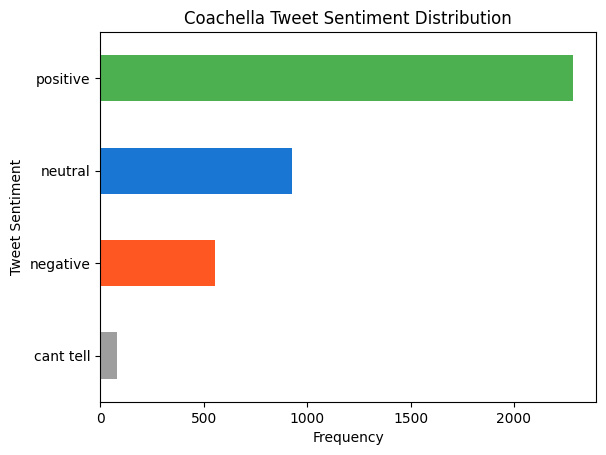

None


In [ ]:
# We are interested in sentiment, so check its distribution
print(raw_coachella_df['coachella_sentiment'].value_counts(), '\n')

ax = raw_coachella_df\
      .groupby('coachella_sentiment')\
      .size()\
      .plot(kind='barh', color=['#9E9E9E', '#FF5722', '#1976D2', '#4CAF50'])
ax.set_title('Coachella Tweet Sentiment Distribution')
ax.set_xlabel('Frequency')
ax.set_ylabel('Tweet Sentiment')
print(plt.show())

       follower_count
count    6.000000e+01
mean     1.858801e+06
std      6.018935e+06
min      1.008300e+04
25%      1.146345e+05
50%      2.930590e+05
75%      7.493610e+05
max      3.930127e+07


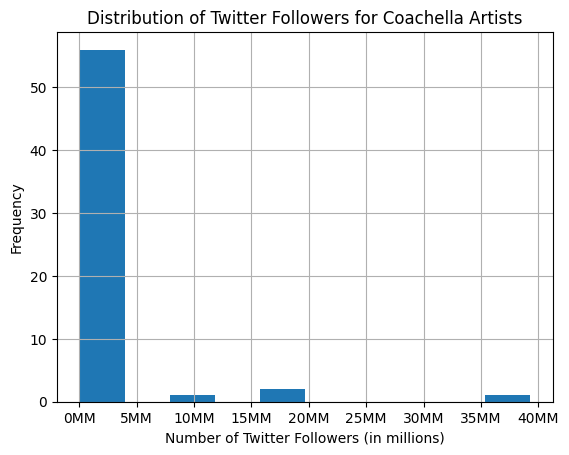

None


In [ ]:
# Also interested in follower count - notice that the max is much higher than
# the rest of the spread and the median is around 300k
print(raw_artist_df.describe())

# Plot the distribution follower count

def millions_formatter(x, pos):
    """
    Formatter function to display tick labels in millions with 'm' as the unit.
    """
    return f"{x / 1e6:.0f}MM"

ax = raw_artist_df['follower_count'].hist()
ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_title('Distribution of Twitter Followers for Coachella Artists')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Twitter Followers (in millions)')
print(plt.show())

[[<Axes: title={'center': 'follower_count'}>]]
[[<Axes: title={'center': 'follower_count'}>]]


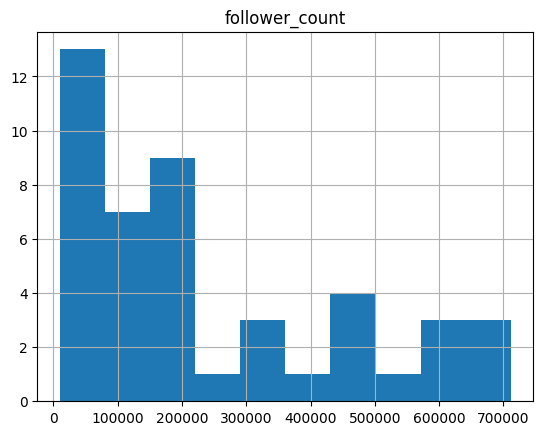

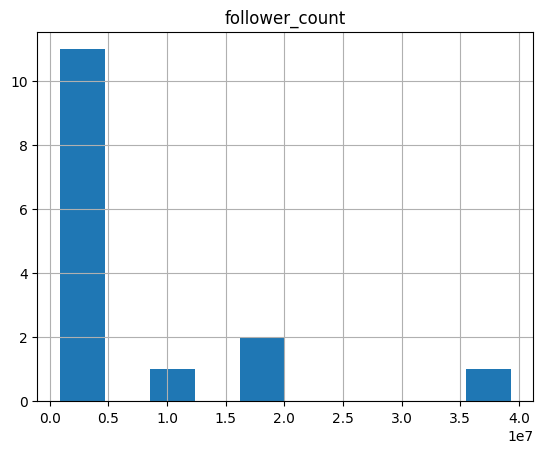

In [ ]:
# Plot below and above .75 quantile
print(raw_artist_df[raw_artist_df['follower_count'] < raw_artist_df['follower_count'].quantile(.75)].hist())
print(raw_artist_df[raw_artist_df['follower_count'] >= raw_artist_df['follower_count'].quantile(.75)].hist())

### Preprocessing

In [ ]:
# Narrow tweets down to the columns we care about
tweets_df = raw_coachella_df.loc[:, ['coachella_sentiment', 'text']]
tweets_df.head()

,coachella_sentiment,text
0,positive,#Coachella2015 tickets selling out in less tha...
1,positive,RT @sudsybuddy: WAIT THIS IS ABSOLUTE FIRE _ÙÓ...
2,positive,#Coachella2015 #VIP passes secured! See you th...
3,positive,PhillyÛªs @warondrugsjams will play #Coachell...
4,positive,If briana and her mom out to #Coachella2015 i...


In [ ]:
# Get tweet counts about each artists
mention_counts = []
neg_counts = []
neutral_counts = []
pos_counts = []
unsure_counts = []
for username in artist_usernames:
    # Use a temporary column to track what tweets mention the artist
    escaped_username = re.escape(f'@{username}')
    pattern = re.compile(escaped_username + r'$|' + escaped_username + r'[^a-zA-Z0-9_]', re.IGNORECASE)
    tweets_df[f'mentions_{username}'] = tweets_df['text'].str.contains(pattern)

    # Get total number of tweets the artist was mentioned in
    mention_counts.append(tweets_df[f'mentions_{username}'].sum())

    # Get number of tweets of each sentiment about an artist (should match total)
    sentiment_counts = tweets_df.groupby('coachella_sentiment').sum(numeric_only=True)
    neg_counts.append(int(sentiment_counts.loc['negative']))
    neutral_counts.append(int(sentiment_counts.loc['neutral']))
    pos_counts.append(int(sentiment_counts.loc['positive']))
    unsure_counts.append(int(sentiment_counts.loc['cant tell']))

    # Delete temporary column
    tweets_df.drop(columns=[f'mentions_{username}'], inplace=True)

In [ ]:
# Append the counts on to the proper artist
artist_df = raw_artist_df.copy()
artist_df['num_mentions'] = mention_counts
artist_df['num_neg_mentions'] = neg_counts
artist_df['num_neutral_mentions'] = neutral_counts
artist_df['num_pos_mentions'] = pos_counts
artist_df['num_unsure_mentions'] = unsure_counts

# Create target/outcome variable
artist_df['over_300k_followers'] = (artist_df['follower_count'] > 300000).astype(int)

artist_df.head()

,username,follower_count,num_mentions,num_neg_mentions,num_neutral_mentions,num_pos_mentions,num_unsure_mentions,over_300k_followers
0,acdc,576188,32,2,10,20,0,1
1,tameimpala,611878,9,0,2,7,0,1
2,interpol,204179,6,0,2,4,0,0
3,alesso,2028366,9,1,1,7,0,1
4,alabama_shakes,156489,7,0,0,6,1,0


### Exploratory Data Analysis (After Preprocessing)

In [ ]:
# Check stats about the final dataset
artist_df.describe()

,follower_count,num_mentions,num_neg_mentions,num_neutral_mentions,num_pos_mentions,num_unsure_mentions,over_300k_followers
count,6.000000e+01,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1.858801e+06,7.166667,0.500000,1.400000,5.166667,0.100000,0.500000
std,6.018935e+06,15.084133,1.631262,3.561565,9.952713,0.354152,0.504219
min,1.008300e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.146345e+05,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2.930590e+05,3.000000,0.000000,0.000000,3.000000,0.000000,0.500000
75%,7.493610e+05,7.000000,0.250000,1.000000,5.250000,0.000000,1.000000
max,3.930127e+07,104.000000,12.000000,24.000000,66.000000,2.000000,1.000000


<ipython-input-115-11965ecdd99b>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=artist_df, x="num_mentions", y="over_300k_followers", palette="viridis", alpha=0.5)


Text(0, 0.5, 'Artist has Over 300k Twitter Followers')

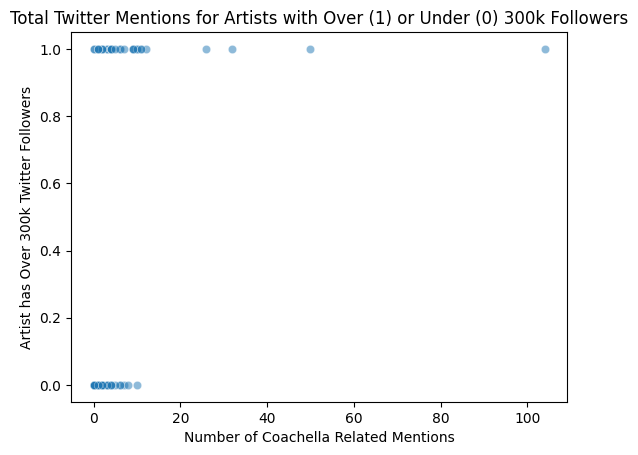

In [ ]:
# Visualize the final dataset
sns.scatterplot(data=artist_df, x="num_mentions", y="over_300k_followers", palette="viridis", alpha=0.5)
plt.title("Total Twitter Mentions for Artists with Over (1) or Under (0) 300k Followers")
plt.xlabel("Number of Coachella Related Mentions")
plt.ylabel("Artist has Over 300k Twitter Followers")

<ipython-input-116-d42310670c51>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=bottom75_artists, x="num_mentions", y="follower_count", palette="viridis", alpha=0.5)


<Axes: xlabel='num_mentions', ylabel='follower_count'>

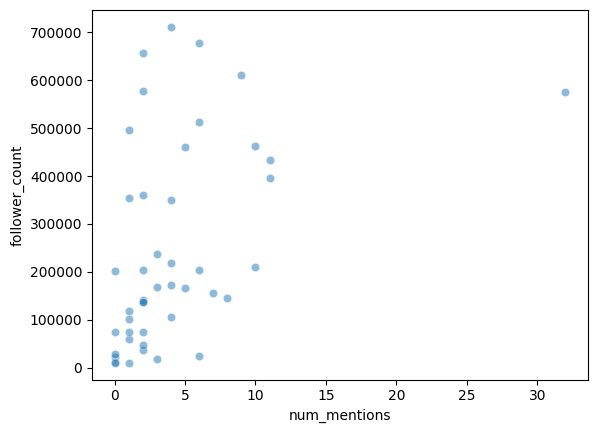

In [ ]:
# Visualize the .75 quantile of followers in the final dataset
bottom75_artists = artist_df[artist_df['follower_count'] < artist_df['follower_count'].quantile(.75)]
sns.scatterplot(data=bottom75_artists, x="num_mentions", y="follower_count", palette="viridis", alpha=0.5)

<ipython-input-117-49694cde50fc>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=top75_artists, x="num_mentions", y="follower_count", palette="viridis", alpha=0.5)


<Axes: xlabel='num_mentions', ylabel='follower_count'>

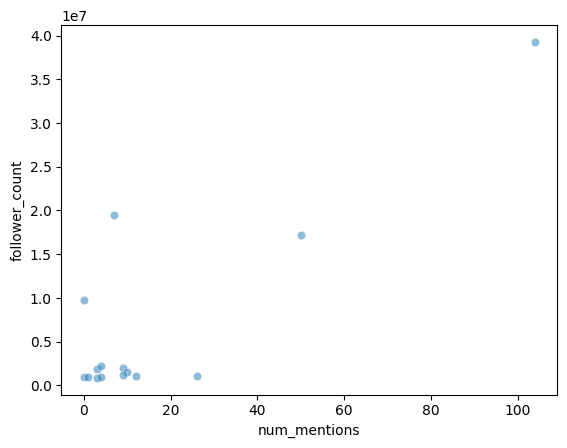

In [ ]:
# Visualize above the .75 quantile of followers in the final dataset
top75_artists = artist_df[artist_df['follower_count'] >= artist_df['follower_count'].quantile(.75)]
sns.scatterplot(data=top75_artists, x="num_mentions", y="follower_count", palette="viridis", alpha=0.5)

### Modelling

In [ ]:
# Separate the data by the outcome for more representative sampling
under300k_artists = artist_df.loc[artist_df['over_300k_followers'] == 0, :]
over300k_artists = artist_df.loc[artist_df['over_300k_followers'] == 1, :]

# Split outcome separated datasets into training and testing sets
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    under300k_artists.loc[:, ['num_neg_mentions',	'num_neutral_mentions',	'num_pos_mentions',	'num_unsure_mentions']],
    under300k_artists['over_300k_followers'],
    test_size=0.25,
    random_state=5356
)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    over300k_artists.loc[:, ['num_neg_mentions',	'num_neutral_mentions',	'num_pos_mentions',	'num_unsure_mentions']],
    over300k_artists['over_300k_followers'],
    test_size=0.25,
    random_state=78130
)

# Combine the random samples from each to form one training set and one testing set
X_train = pd.concat([X_train_under, X_train_over])
X_test = pd.concat([X_test_under, X_test_over])
y_train = pd.concat([y_train_under, y_train_over])
y_test_ = pd.concat([y_test_under, y_test_over])

print('Training set size:', len(X_train))
print('Testing set size:', len(X_test))

Training set size: 44
Testing set size: 16


In [ ]:
# Create and fit a logistic regression model on the training data
model = LogisticRegression(max_iter=1000)
result = model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

y_test = y_test_.to_numpy()
print('Actual Labels:'.ljust(20), y_test)
print('Predicted Labels:'.ljust(20), y_pred)

Actual Labels:       [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Predicted Labels:    [0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0]


In [ ]:
# neg, neut, pos, unsure
model.coef_

array([[ 0.90437842,  0.24672228,  0.14524724, -0.39482227]])

### Performance Evaluation

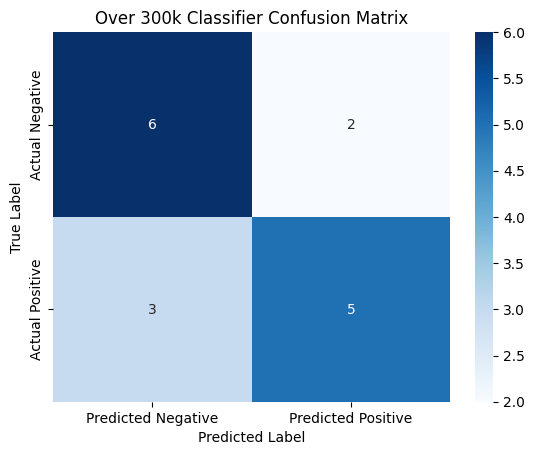

In [ ]:
# Calculate the confusion matrix for the model
c_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(c_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Over 300k Classifier Confusion Matrix')
plt.show()

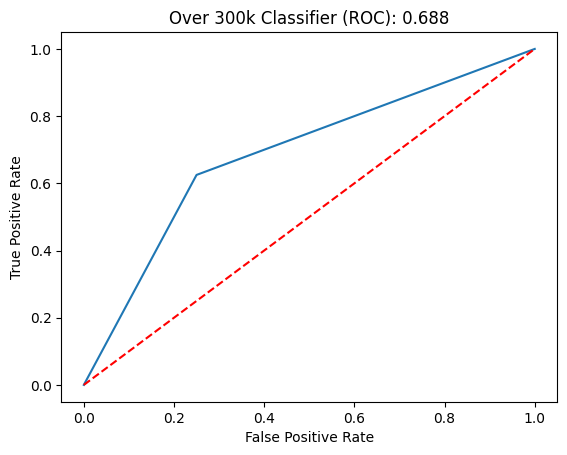

In [ ]:
# Calculate AUROC for model
fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False)
auroc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--r')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Over 300k Classifier (ROC): ' + str(round(auroc,3)))
plt.show()

In [ ]:
# Calculate standard performance metrics
TN, FP, FN, TP = c_mat.ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
specificity = TN/(TN + FP)
f1 = f1_score(y_test, y_pred)

# Report the metrics
print("Accuracy:".ljust(15), round(accuracy, 2))
print("Precision:".ljust(15), round(precision, 2))
print("Recall:".ljust(15), round(recall, 2))
print("Specificity".ljust(15), round(specificity, 2))
print("F1 Score:".ljust(15), round(f1, 2))
print("AUROC Score:".ljust(15), round(auroc, 2))

Accuracy:       0.69
Precision:      0.71
Recall:         0.62
Specificity     0.75
F1 Score:       0.67
AUROC Score:    0.69
